# 一维Burgers问题

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_burgers1D.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindflow/zh_cn/physics_driven/mindspore_burgers1D.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/docs/mindflow/docs/source_zh_cn/physics_driven/burgers1D.ipynb)

本案例要求**MindSpore版本 >= 2.0.0**调用如下接口: *mindspore.jit，mindspore.jit_class，mindspore.jacrev*。

## 概述

计算流体力学是21世纪流体力学领域的重要技术之一，其通过使用数值方法在计算机中对流体力学的控制方程进行求解，从而实现流动的分析、预测和控制。传统的有限元法（finite element method，FEM）和有限差分法（finite difference method，FDM）常囿于复杂的仿真流程（物理建模，网格划分，数值离散，迭代求解等）和较高的计算成本，往往效率低下。因此，借助AI提升流体仿真效率是十分必要的。

在经典理论与结合计算机性能的数值求解方法的发展趋于平缓的时候，近年来机器学习方法通过神经网络结合大量数据，实现流场的快速仿真，获得了接近传统方法的求解精度，为流场求解提供了新思路。

伯格斯方程（Burgers' equation）是一个模拟冲击波的传播和反射的非线性偏微分方程，被广泛应用于流体力学，非线性声学，气体动力学等领域，它以约翰内斯·马丁斯汉堡（1895-1981）的名字命名。本案例采用MindFlow流体仿真套件，基于物理驱动的PINNs (Physics Informed Neural Networks)方法，求解一维有粘性情况下的Burgers方程。

## 问题描述

Burgers'方程的形式如下：

$$
u_t + uu_x = \epsilon u_{xx}, \quad x \in[-1,1], t \in[0, T],
$$

其中$\epsilon=0.01/\pi$，等号左边为对流项，右边为耗散项，本案例使用迪利克雷边界条件和正弦函数的初始条件，形式如下：

$$
u(t, -1) = u(t, 1) = 0,
$$

$$
u(0, x) = -sin(\pi x),
$$

本案例利用PINNs方法学习位置和时间到相应物理量的映射$(x, t) \mapsto u$，实现Burgers'方程的求解。

## 技术路径

MindFlow求解该问题的具体流程如下：

1. 创建数据集。
2. 构建模型。
3. 优化器。
4. Burgers1D。
5. 模型训练。
6. 模型推理及可视化。

In [1]:
import time

import numpy as np
import sympy

import mindspore
from mindspore import context, nn, ops, Tensor, jit, set_seed
from mindspore import dtype as mstype
from mindspore import load_checkpoint, load_param_into_net

下述`src`包可以在[applications/physics_driven/burgers/src](https://gitee.com/mindspore/mindscience/tree/master/MindFlow/applications/physics_driven/burgers/src)下载。

In [2]:
from mindflow.pde import Burgers, sympy_to_mindspore
from mindflow.cell import MultiScaleFCSequential
from mindflow.utils import print_log
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, visual, calculate_l2_error

set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)
use_ascend = context.get_context(attr_key='device_target') == "Ascend"

In [4]:
# load configurations
config = load_yaml_config(args.config_file_path)

## 创建数据集

本案例根据求解域、初始条件及边值条件进行随机采样，生成训练数据集与测试数据集，具体设置如下：

下载测试数据集： [physics_driven/burgers_pinns/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/burgers_pinns/dataset/) 。

In [5]:
# create training dataset
burgers_train_dataset = create_training_dataset(config)
train_dataset = burgers_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                     shuffle=True,
                                                     prebatched_data=True,
                                                     drop_remainder=True)
# create test dataset
inputs, label = create_test_dataset(config["test_dataset_path"])

## 构建模型

本例使用简单的全连接网络，深度为6层，激发函数为`tanh`函数。

In [6]:
# define models and optimizers
model = MultiScaleFCSequential(in_channels=config["model"]["in_channels"],
                               out_channels=config["model"]["out_channels"],
                               layers=config["model"]["layers"],
                               neurons=config["model"]["neurons"],
                               residual=config["model"]["residual"],
                               act=config["model"]["activation"],
                               num_scales=1)
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)


## 优化器

In [7]:
# define optimizer
optimizer = nn.Adam(model.trainable_params(), config["optimizer"]["initial_lr"])

## Burgers1D

下述`Burgers1D`将Burgers 1-D问题同数据集关联起来，包含3个部分：控制方程，边界条件和初始条件。


In [8]:
class Burgers1D(Burgers):
    def __init__(self, model, loss_fn=nn.MSELoss()):
        super(Burgers1D, self).__init__(model, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def ic(self):
        ic_eq = self.u + sympy.sin(np.pi * self.x)
        equations = {"ic": ic_eq}
        return equations

    def bc(self):
        bc_eq = self.u
        equations = {"bc": bc_eq}
        return equations

    def get_loss(self, pde_data, ic_data, bc_data):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_loss = self.loss_fn(pde_res[0], Tensor(np.array([0.0]), mstype.float32))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_loss = self.loss_fn(ic_res[0], Tensor(np.array([0.0]), mstype.float32))

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_loss = self.loss_fn(bc_res[0], Tensor(np.array([0.0]), mstype.float32))

        return pde_loss + ic_loss + bc_loss

## 模型训练

使用**MindSpore >= 2.0.0**的版本，可以使用函数式编程范式训练神经网络。

In [9]:
def train():
    '''Train and evaluate the network'''
    problem = Burgers1D(model)

    if use_ascend:
        from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')
    else:
        loss_scaler = None

    # the loss function receives 3 data sources: pde, ic and bc
    def forward_fn(pde_data, ic_data, bc_data):
        loss = problem.get_loss(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.scale(loss)

        return loss

    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data, ic_data, bc_data):
        loss, grads = grad_fn(pde_data, ic_data, bc_data)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            is_finite = all_finite(grads)
            if is_finite:
                grads = loss_scaler.unscale(grads)
                loss = ops.depend(loss, optimizer(grads))
            loss_scaler.adjust(is_finite)
        else:
            loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = train_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, train_dataset, sink_size=1)
    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs):
            step_train_loss = sink_process()
        print_log(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            calculate_l2_error(model, inputs, label, config["train_batch_size"])

In [10]:
start_time = time.time()
train()
print_log("End-to-End total time: {} s".format(time.time() - start_time))

burgers: u(x, t)*Derivative(u(x, t), x) + Derivative(u(x, t), t) - 0.00318309897556901*Derivative(u(x, t), (x, 2))
    Item numbers of current derivative formula nodes: 3
ic: u(x, t) + sin(3.14159265358979*x)
    Item numbers of current derivative formula nodes: 2
bc: u(x, t)
    Item numbers of current derivative formula nodes: 1


epoch: 100 train loss: 0.42995507 epoch time: 63.536 ms
    predict total time: 243.24369430541992 ms
    l2_error:  0.8788317251751688
epoch: 200 train loss: 0.41935205 epoch time: 62.145 ms
    predict total time: 7.87043571472168 ms
    l2_error:  0.88964679457787
epoch: 300 train loss: 0.42547783 epoch time: 62.736 ms
    predict total time: 7.727861404418945 ms
    l2_error:  0.8895206005088669
epoch: 400 train loss: 0.4227412 epoch time: 62.124 ms
    predict total time: 7.363557815551758 ms
    l2_error:  0.8889956873924331
epoch: 500 train loss: 0.41943315 epoch time: 62.960 ms
    predict total time: 4.832983016967773 ms
    l2_error:  0.8881562175445344
...
epoch: 14600 train loss: 0.00013843024 epoch time: 62.264 ms
predict total time: 5.646228790283203 ms
l2_error:  0.004415987361258303
epoch: 14700 train loss: 7.498202e-05 epoch time: 62.589 ms
    predict total time: 5.714178085327148 ms
    l2_error:  0.004421070906100957
epoch: 14800 train loss: 0.00018732375 epoch time

## 模型推理及可视化

训练后可对流场内所有数据点进行推理，并可视化相关结果。

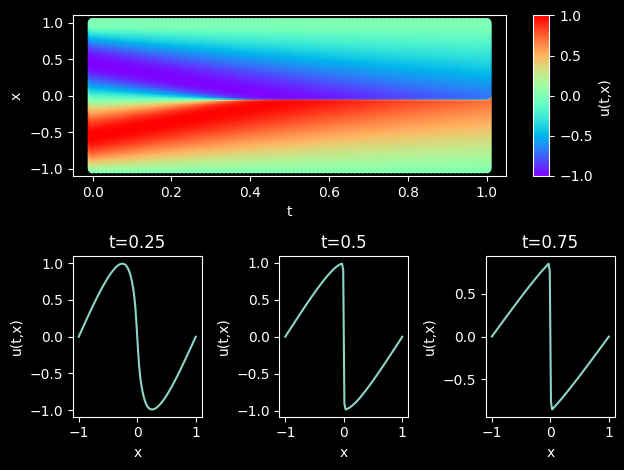

In [11]:
# visualization
epochs = config["train_epochs"]
visual(model, epochs=epochs, resolution=config["visual_resolution"])